## Import some helpful libraries

In [1]:
import os     # operating system interfaces
import fnmatch
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib; print("NiBabel version is ", nib.__version__)
from nibabel.testing import data_path
import math
import pandas as pd
import sys
import h5py; print("H5py version is\t\t", h5py.__version__)
import sklearn; print("Scikit-learn version is\t", sklearn.__version__)
import tensorflow as tf; print("TensorFlow version is\t", tf.__version__)
import keras; print("Keras version is ", keras.__version__)
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard

NiBabel version is  3.2.0
H5py version is		 2.10.0
Scikit-learn version is	 0.23.2
TensorFlow version is	 2.3.1
Keras version is  2.3.1


Using TensorFlow backend.


## Loading Dataset:Validation and Training Dataset (randomly)

In [2]:
## Loading all datasets from path directory

# example_filename = os.path.join(data_path, 'example4d.nii.gz')
print(os.getcwd())     # '/Users/shossein/GitHub/DTI_Clustering'
dirpath = os.chdir("/Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI")
print("\nDirectory is changed into:\n", os.getcwd(), "\n") 
sample_all = []
for sample in fnmatch.filter(os.listdir(dirpath), 'Pat_*_1-post.nii.gz'):
    sample_all.append(sample)
sample_num = len(sample_all)
print("There are", sample_num, "samples.\n")
sample_all.sort()
# print(*sample_all, sep='\t')

/Users/shossein/GitHub/DTI_Clustering

Directory is changed into:
 /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI 

There are 124 samples.



In [3]:
## Deviding all samples into two groups: Training and Validation datasets randomly

sample_val = random.sample(sample_all, 24)
sample_val.sort()
print(len(sample_val), "Validation samples are:\n")
print(*sample_val, sep='\t')

sample_val_subset = sample_val [0:3]
print("\n\n", len(sample_val_subset), " subset of Validation samples are:\n")
print(*sample_val_subset, sep='\t')

sample_train = [x for x in sample_all if x not in sample_val]
sample_train.sort()
print("\n--------------------------------------------------------------------------------\n", len(sample_train), "Training samples are:\n")
print(*sample_train, sep='\t')

sample_train_subset = sample_train [0:5]
print("\n\n", len(sample_train_subset), " subset of Validation samples are:\n")
print(*sample_train_subset, sep='\t')

24 Validation samples are:

Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_118_1-post.nii.gz	Pat_128_1-post.nii.gz	Pat_129_1-post.nii.gz	Pat_130_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_30_1-post.nii.gz	Pat_38_1-post.nii.gz	Pat_41_1-post.nii.gz	Pat_43_1-post.nii.gz	Pat_45_1-post.nii.gz	Pat_51_1-post.nii.gz	Pat_53_1-post.nii.gz	Pat_56_1-post.nii.gz	Pat_79_1-post.nii.gz	Pat_7_1-post.nii.gz	Pat_83_1-post.nii.gz	Pat_87_1-post.nii.gz	Pat_92_1-post.nii.gz	Pat_95_1-post.nii.gz	Pat_98_1-post.nii.gz	Pat_99_1-post.nii.gz


 3  subset of Validation samples are:

Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_114_1-post.nii.gz

--------------------------------------------------------------------------------
 100 Training samples are:

Pat_100_1-post.nii.gz	Pat_101_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_10_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_115_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat

## Combine datasets together

In [4]:
## Combine all Training dateset together

data_combined = np.zeros((1, 182, 218, 182, 1))

sample_train = sample_train_subset            # To test in CPU based computer

for sample in sample_train_subset:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of training dataset:", data_combined.shape)
train_data = data_combined

Shape of training dataset: (5, 182, 218, 182, 1)


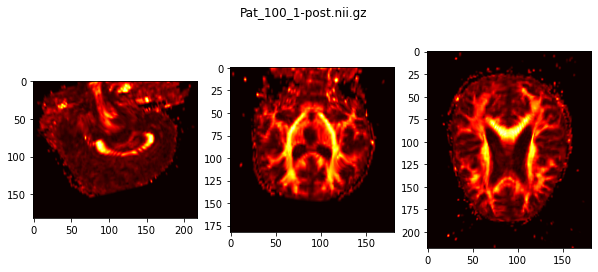

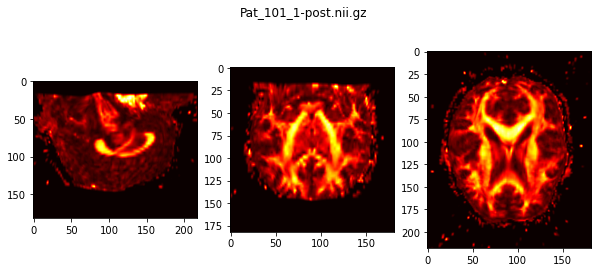

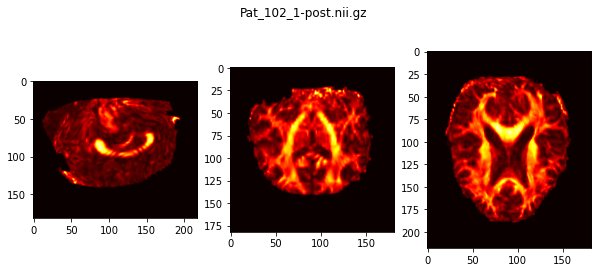

In [18]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train[m], x=0.5, y=0.9)

In [6]:
## Rescale Training dataset into [0:1]

sample_spec = 2      # A specific sample to show the min and max of that 
print("Range of a sample of original training data:\tMin=", np.min(train_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(train_data[sample_spec, :, :, :, 0]), "\n")
for m in range(train_data.shape[0]):
    for x in range(train_data.shape[1]):
        for y in range(train_data.shape[2]):
            for z in range(train_data.shape[3]):
                if train_data[m,x,y,z] <= 0: train_data[m,x,y,z] = 0
                if train_data[m,x,y,z] > 1: train_data[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(train_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(train_data[sample_spec, :, :, :, 0]), "\n")

Range of a sample of original training data:	Min= -0.0010085757821798325 ,   Max= 0.9992789626121521 

Range of a sample of original data:		Min= 0.0 ,   Max= 0.9992789626121521 



In [7]:
## Combine all Validation dateset together

data_combined = np.zeros((1, 182, 218, 182, 1))

sample_val = sample_val_subset            # To test in CPU based computer

for sample in sample_val:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of validation dataset:", data_combined.shape)
valid_data = data_combined

Shape of validation dataset: (3, 182, 218, 182, 1)


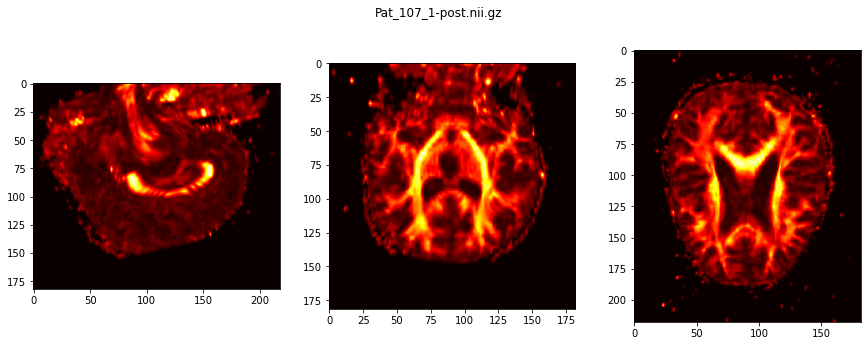

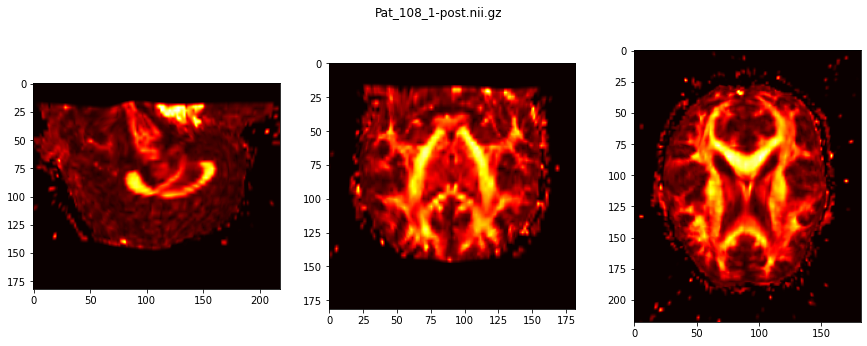

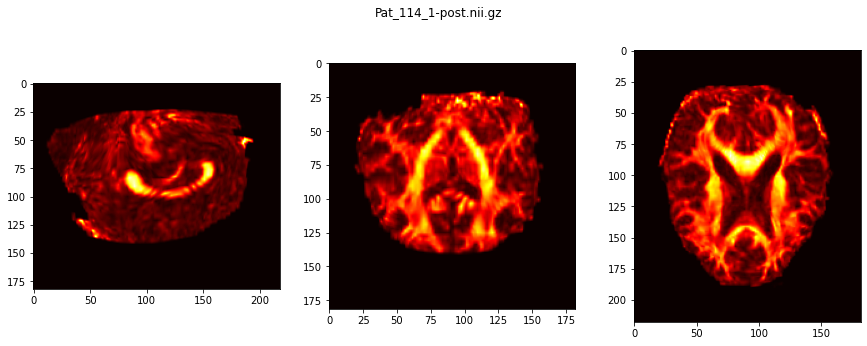

In [8]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val[m], x=0.5, y=1)

In [9]:
## Rescale Validation dataset into [0:1]

sample_spec = 2      # A specific sample to show the min and max of that 

print("Range of a sample of original validation data:\tMin=", np.min(valid_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(valid_data[sample_spec, :, :, :, 0]), "\n")
for m in range(valid_data.shape[0]):
    for x in range(valid_data.shape[1]):
        for y in range(valid_data.shape[2]):
            for z in range(valid_data.shape[3]):
                if valid_data[m,x,y,z] <= 0: valid_data[m,x,y,z] = 0
                if valid_data[m,x,y,z] > 1: valid_data[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(valid_data[sample_spec, :, :, :, 0]), ",   Max=", np.max(valid_data[sample_spec, :, :, :, 0]), "\n")

Range of a sample of original validation data:	Min= 0.0 ,   Max= 0.9975343942642212 

Range of a sample of original data:		Min= 0.0 ,   Max= 0.9975343942642212 



## Model Design

In [10]:
## Define parameters:

IMAGE_HEIGHT = data_combined.shape[1]
IMAGE_WIDTH = data_combined.shape[2]
IMAGE_DEPTH = data_combined.shape[3]
batch_size = 32
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same', name='Conv1')(input_img)
x = MaxPooling3D((13, 13, 13), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same', name='Conv2')(x)
encoded = MaxPooling3D((7, 7, 7), padding='same')(x)
## at this point the representation is (2, 3, 2, 8) i.e. 96-dimensional instead of 7,221,032

## Decoder
x = Conv3DTranspose(4, (3, 3, 3), activation='relu', padding='same', name='DeConv3')(encoded)
x = UpSampling3D((7, 6, 7))(x)
x = Conv3DTranspose(8, (3, 3, 3), activation='relu', padding='same', name='DeConv4')(x)
x = UpSampling3D((13, 12, 13))(x)
decoded = Conv3DTranspose(1, (1, 3, 1), activation='sigmoid', padding='valid', name='DeConv5')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
autoencoder.summary()

input-layer shape: [32, 182, 218, 182, 1]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 182, 218, 182, 16) 448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 17, 14, 16)    0         
_________________________________________________________________
Conv2 (Conv3D)               (None, 14, 17, 14, 8)     3464      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 3, 2, 8)        0         
_________________________________________________________________
DeConv3 (Conv3DTranspose)    (None, 2, 3, 2, 4)        868       
_________________________________________________________________
up_sampling3

## Model Training

In [11]:
print(os.getcwd())
dirpath = os.chdir("/Users/shossein/GitHub/DTI_Clustering")
print("\nDirectory is changed into:\n", os.getcwd(), "\n")

/Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI

Directory is changed into:
 /Users/shossein/GitHub/DTI_Clustering 



In [13]:
## Tensorboard

%load_ext tensorboard
# %reload_ext tensorboard
logdir = os.path.join("CAE_logs", datetime.datetime.now().strftime("%Y_%m_%d____%H_%M_%S"))
tb_callback = TensorBoard(logdir, histogram_freq=1)

## Midel Fit
autoencoder.fit(train_data, train_data, epochs=3, batch_size=batch_size, shuffle=True, validation_data=(valid_data, valid_data), callbacks=[tb_callback], verbose=1)

Epoch 1/3
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923
Epoch 2/3
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923
Epoch 3/3
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.3764 - val_loss: 0.0000e+00 - val_accuracy: 0.3923


In [14]:
tensorboard --logdir=CAE_logs

Reusing TensorBoard on port 6008 (pid 11747), started 0:11:36 ago. (Use '!kill 11747' to kill it.)

In [15]:
tensorboard --logdir=CAE_logs

Reusing TensorBoard on port 6008 (pid 11747), started 0:11:41 ago. (Use '!kill 11747' to kill it.)